In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from prophet import Prophet

# -------------------------------
# 1. Load and Preprocess Data
# -------------------------------

# Load dataset
df = pd.read_csv(r'D:\Projects\quantum forecasting\dataset\kaggle data\Solar_Prediction.csv')

# Combine 'Data' and 'Time' into a single datetime column
df['datetime'] = pd.to_datetime(df['Data'].astype(str) + ' ' + df['Time'], errors='coerce')

# Drop unnecessary columns
df.drop(['UNIXTime', 'TimeSunRise', 'TimeSunSet'], axis=1, inplace=True)

# -----------------------------------
# 2. Prepare data for Prophet model
# -----------------------------------

prophet_df = pd.DataFrame({
    "ds": df["datetime"],
    "y": df["Radiation"]
})

# Initialize Prophet with custom seasonality
model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False,
    changepoint_prior_scale=0.5
)
model.add_seasonality(name='daily', period=1440, fourier_order=25)   # 1440 minutes in a day
model.add_seasonality(name='hourly', period=60, fourier_order=15)     # 60 minutes in an hour
model.add_seasonality(name='weekly', period=10080, fourier_order=20)  # 10080 minutes in a week

# Fit Prophet model
model.fit(prophet_df)

# Forecast for training data
forecast = model.predict(prophet_df[["ds"]])

# --------------------------------------------
# 3. Add trend & seasonality components to df
# --------------------------------------------

df["trend"] = forecast["trend"]
df["daily_seasonality"] = forecast["daily"]
df["hourly_seasonality"] = forecast["hourly"]
df["weekly_seasonality"] = forecast["weekly"]
df["seasonal"] = df["daily_seasonality"] + df["hourly_seasonality"] + df["weekly_seasonality"]
df["residual"] = df["Radiation"] - df["trend"] - df["seasonal"]

# ---------------------------------------
# 4. Extract additional time features
# ---------------------------------------

df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second

# Drop unused original columns
df.drop(['Data', 'Time', 'datetime'], axis=1, inplace=True)

# -----------------------------------------------------
# 5. Prepare features and target for ML model
# -----------------------------------------------------

input_features = [
    "trend", "seasonal", 'daily_seasonality', 'hourly_seasonality', 'weekly_seasonality',
    'Temperature', 'Pressure', 'Humidity',
    'WindDirection(Degrees)', 'Speed', 'month', 'day', 'hour', 'minute', 'second'
]

X = df[input_features]
y = df["residual"].values.reshape(-1, 1)

# ---------------------------------------
# 6. Train/test split and feature scaling
# ---------------------------------------

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize features
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Standardize target
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)


d:\Python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Vyshnav Kumar\AppData\Local\Temp\ipykernel_372\760667280.py:14: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['Data'].astype(str) + ' ' + df['Time'], errors='coerce')
19:05:38 - cmdstanpy - INFO - Chain [1] start processing
19:05:49 - cmdstanpy - INFO - Chain [1] done processing


In [2]:
X_train = X_train[0:4500]
y_train = y_train[0:4500]
X_test = X_test[4500:5500]
y_test = y_test[4500:5500]

In [3]:
import numpy as np

# Corrected array (comma-separated values)
drop = [861, 898, 512, 384, 192, 929, 134, 724, 204, 268, 488, 515, 178, 667, 443, 69, 369, 822,
    589, 895, 389, 325, 162, 882, 872, 253, 850, 164, 915, 997, 41, 348, 442, 498, 695, 285,
    920, 354, 811, 716, 165, 571, 993, 553, 468, 48, 832, 405, 108, 950]


# Convert to a NumPy array if not already
X_test = np.delete(X_test, drop, axis=0)
y_test = np.delete(y_test, drop, axis=0)


In [4]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# ---- Device Setup ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"💻 Using device: {device}")

# ---- Hyperparameters ----
n_qubits = 4
n_layers = 2
theta_dim = 4
num_blocks = 2
epochs = 70
lr = 1e-3
batch_size = 8
forecast_dim = 1

# ---- Quantum device ----
dev = qml.device("lightning.qubit", wires=n_qubits)

# ---- Quantum circuit ----
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits), rotation="Y")
    for layer_weights in weights:
        for i in range(n_qubits):
            qml.RY(layer_weights[i], wires=i)
        for i in range(0, n_qubits - 1, 2):
            qml.CZ(wires=[i, i + 1])
        for i in range(1, n_qubits - 1, 2):
            qml.CZ(wires=[i, i + 1])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# ---- QNode and TorchLayer ----
weight_shapes = {"weights": (n_layers, n_qubits)}
qnode = qml.QNode(quantum_circuit, dev, interface="torch", diff_method="adjoint")
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

# ==== Quantum N-HiTS Block ====
class QuantumNHITSBlock(nn.Module):
    def __init__(self, input_dim, theta_dim, forecast_dim):
        super().__init__()
        self.fc_in = nn.Linear(input_dim, n_qubits)
        self.norm = nn.LayerNorm(n_qubits)
        self.q_layer = qlayer
        self.theta_fc = nn.Linear(n_qubits, theta_dim)
        self.backcast_fc = nn.Linear(theta_dim, input_dim)
        self.forecast_fc = nn.Linear(theta_dim, forecast_dim)

    def forward(self, x):
        x = self.norm(self.fc_in(x))
        x_q = self.q_layer(x)
        theta = self.theta_fc(x_q)
        backcast = self.backcast_fc(theta)
        forecast = self.forecast_fc(theta)
        return backcast, forecast

# ==== Quantum N-HiTS Model ====
class QuantumNHITS(nn.Module):
    def __init__(self, input_dim, theta_dim, forecast_dim, num_blocks=3):
        super().__init__()
        self.blocks = nn.ModuleList([
            QuantumNHITSBlock(input_dim, theta_dim, forecast_dim)
            for _ in range(num_blocks)
        ])

    def forward(self, x):
        forecast_total = 0
        for block in self.blocks:
            backcast, forecast = block(x)
            forecast_total += forecast
            x = x - backcast
        return forecast_total

# ---- Convert to tensors ----
X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1).to(device)

# ---- DataLoaders ----
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=len(X_test_t), shuffle=False)

# ---- Initialize model and training components ----
model = QuantumNHITS(input_dim=X_train.shape[1], theta_dim=theta_dim, forecast_dim=forecast_dim, num_blocks=num_blocks).to(device)
criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

💻 Using device: cuda


d:\Python\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [5]:
# ---- Training loop ----
train_losses = []
test_losses = []

best_val_loss = float('inf')
best_model_path = r"D:\Projects\quantum forecasting\models\best_quantum_model.pth"

print("Starting training...\n")

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        preds = model(batch_x)
        loss = criterion(preds, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Evaluation
    model.eval()
    with torch.no_grad():
        test_x, test_y = next(iter(test_loader))
        test_preds = model(test_x)
        test_loss = criterion(test_preds, test_y)

    train_losses.append(avg_train_loss)
    test_losses.append(test_loss.item())
    scheduler.step(avg_train_loss)

    print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Test Loss: {test_loss.item():.4f}")

    # Save best model
    if test_loss.item() < best_val_loss:
        best_val_loss = test_loss.item()
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Saved new best model at epoch {epoch+1} with val loss {best_val_loss:.4f}")

print("\nTraining complete.")

Starting training...

Epoch 1/70 - Train Loss: 0.2336 - Test Loss: 0.1181
✅ Saved new best model at epoch 1 with val loss 0.1181
Epoch 2/70 - Train Loss: 0.1215 - Test Loss: 0.0882
✅ Saved new best model at epoch 2 with val loss 0.0882
Epoch 3/70 - Train Loss: 0.0947 - Test Loss: 0.0739
✅ Saved new best model at epoch 3 with val loss 0.0739
Epoch 4/70 - Train Loss: 0.0824 - Test Loss: 0.0672
✅ Saved new best model at epoch 4 with val loss 0.0672
Epoch 5/70 - Train Loss: 0.0755 - Test Loss: 0.0600
✅ Saved new best model at epoch 5 with val loss 0.0600
Epoch 6/70 - Train Loss: 0.0710 - Test Loss: 0.0587
✅ Saved new best model at epoch 6 with val loss 0.0587
Epoch 7/70 - Train Loss: 0.0682 - Test Loss: 0.0586
✅ Saved new best model at epoch 7 with val loss 0.0586
Epoch 8/70 - Train Loss: 0.0678 - Test Loss: 0.0558
✅ Saved new best model at epoch 8 with val loss 0.0558
Epoch 9/70 - Train Loss: 0.0663 - Test Loss: 0.0552
✅ Saved new best model at epoch 9 with val loss 0.0552
Epoch 10/70 - T

In [5]:
# Move model to the appropriate device
model = QuantumNHITS(input_dim=X_test.shape[1], theta_dim=theta_dim, forecast_dim=forecast_dim, num_blocks=num_blocks)
best_model_path = r"D:\Projects\quantum forecasting\models\best_Qmodel_nhits2.pth"
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)

# Move tensors to the same device
X_test_t = X_test_t.to(device)
y_test_t = y_test_t.to(device)

# Inference
model.eval()
with torch.no_grad():
    y_pred = model(X_test_t)
    test_loss = criterion(y_pred, y_test_t)
    print(f"✅ Loaded best model - Test Loss: {test_loss.item():.4f}")

C:\Users\Vyshnav Kumar\AppData\Local\Temp\ipykernel_372\1960541186.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_

✅ Loaded best model - Test Loss: 0.0364


In [7]:
from torchinfo import summary

# Assuming batch size 32
summary(model, input_size=(16, X_train.shape[1]))

Layer (type:depth-idx)                   Output Shape              Param #
QuantumNHITS                             [16, 1]                   --
├─ModuleList: 1-1                        --                        --
│    └─QuantumNHITSBlock: 2-1            [16, 15]                  108
│    │    └─Linear: 3-1                  [16, 4]                   64
│    │    └─LayerNorm: 3-2               [16, 4]                   8
│    └─QuantumNHITSBlock: 2-2            --                        (recursive)
│    │    └─TorchLayer: 3-3              [16, 4]                   8
│    └─QuantumNHITSBlock: 2-3            --                        (recursive)
│    │    └─Linear: 3-4                  [16, 4]                   20
│    │    └─Linear: 3-5                  [16, 15]                  75
│    │    └─Linear: 3-6                  [16, 1]                   5
│    └─QuantumNHITSBlock: 2-4            [16, 15]                  8
│    │    └─Linear: 3-7                  [16, 4]                   64


In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Ensure predictions and targets are NumPy arrays
y_pred_np = y_pred.cpu().numpy().flatten()
y_test_np = y_test_t.cpu().numpy().flatten()

# Compute accuracy metrics
mae = mean_absolute_error(y_test_np, y_pred_np)
mse = mean_squared_error(y_test_np, y_pred_np)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_np, y_pred_np)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 0.1614
Mean Squared Error (MSE): 0.0745
Root Mean Squared Error (RMSE): 0.2730
R² Score: 0.9170


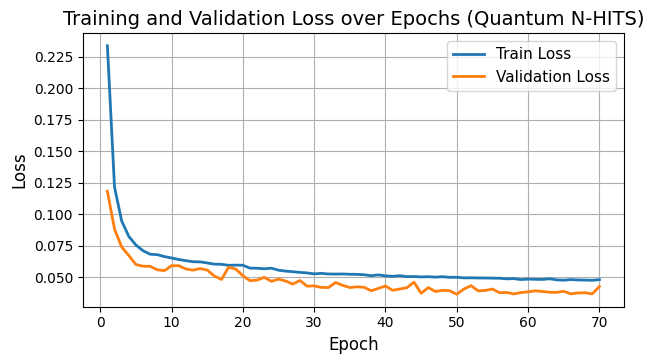

In [9]:
import matplotlib.pyplot as plt

# Apply journal style formatting
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 14
})

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(6.5, 3.8))  # IEEE 1-column size

plt.plot(epochs, train_losses, label='Train Loss', linewidth=2)
plt.plot(epochs, test_losses, label='Validation Loss', linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs (Quantum N-HITS)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save high-resolution version
plt.savefig(r"D:\Projects\quantum forecasting\plots\NASA\QNHITS\loss_curve.png", dpi=300, bbox_inches='tight')
plt.show()


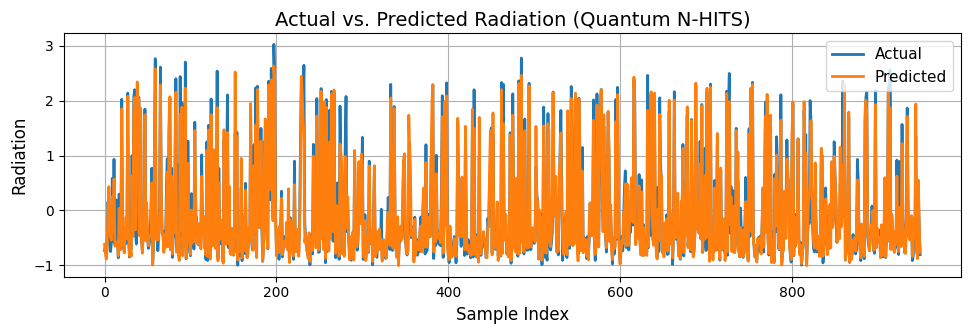

In [7]:
import matplotlib.pyplot as plt

# Set global font styles for publication quality
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 14
})

# Create plot
plt.figure(figsize=(10, 3.5))  # Ideal for one-column width (approx 3.5–3.7 in in journals)
plt.plot(y_test_np, label='Actual', linewidth=2)
plt.plot(y_pred_np, label='Predicted', linewidth=2)

plt.title("Actual vs. Predicted Radiation (Quantum N-HITS)")
plt.xlabel("Sample Index")
plt.ylabel("Radiation")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

# Save high-resolution figure
plt.savefig(r"D:\Projects\quantum forecasting\plots\NASA\QNHITS\actual_vs_predicted.png", dpi=300, bbox_inches='tight')

plt.show()


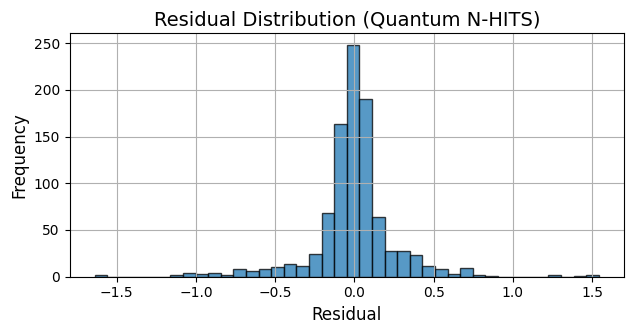

In [11]:
import matplotlib.pyplot as plt

# Set publication-style font configuration
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 14
})

residuals = y_test_np - y_pred_np

# Plot residual histogram
plt.figure(figsize=(6.5, 3.5))  # Suitable for 1-column figure (IEEE ~3.5 in width)
plt.hist(residuals, bins=40, alpha=0.75, edgecolor='black')

plt.title("Residual Distribution (Quantum N-HITS)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()

# Save high-resolution image
plt.savefig(r"D:\Projects\quantum forecasting\plots\NASA\QNHITS\residual_distribution.png", dpi=300, bbox_inches='tight')

plt.show()


d:\Python\lib\site-packages\torch\autograd\graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


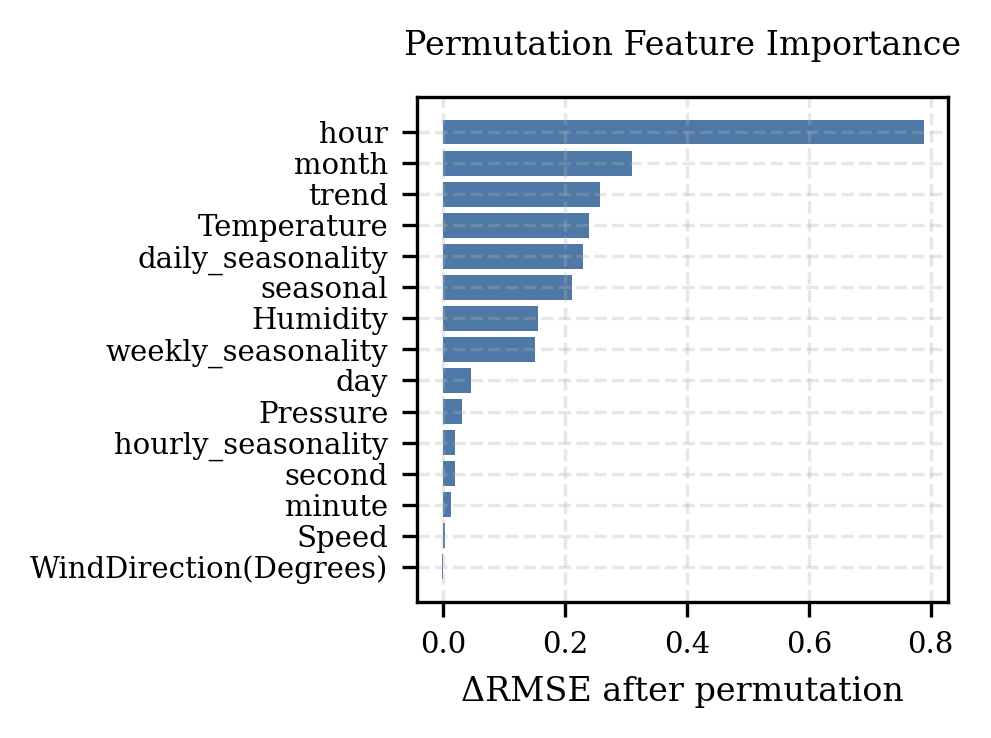

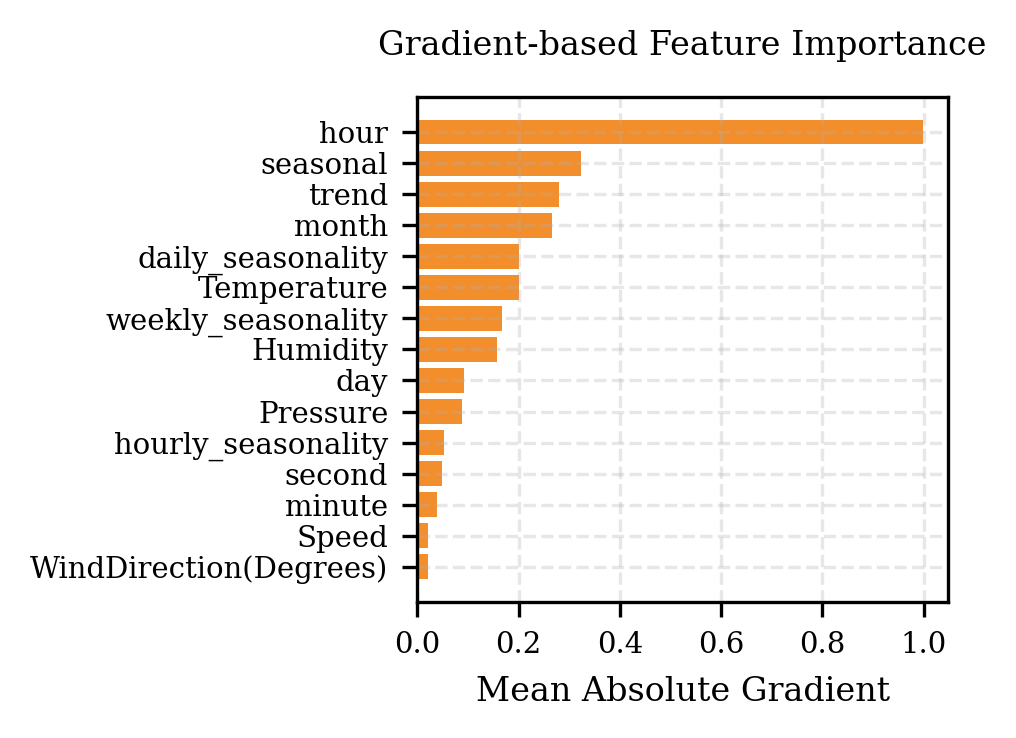

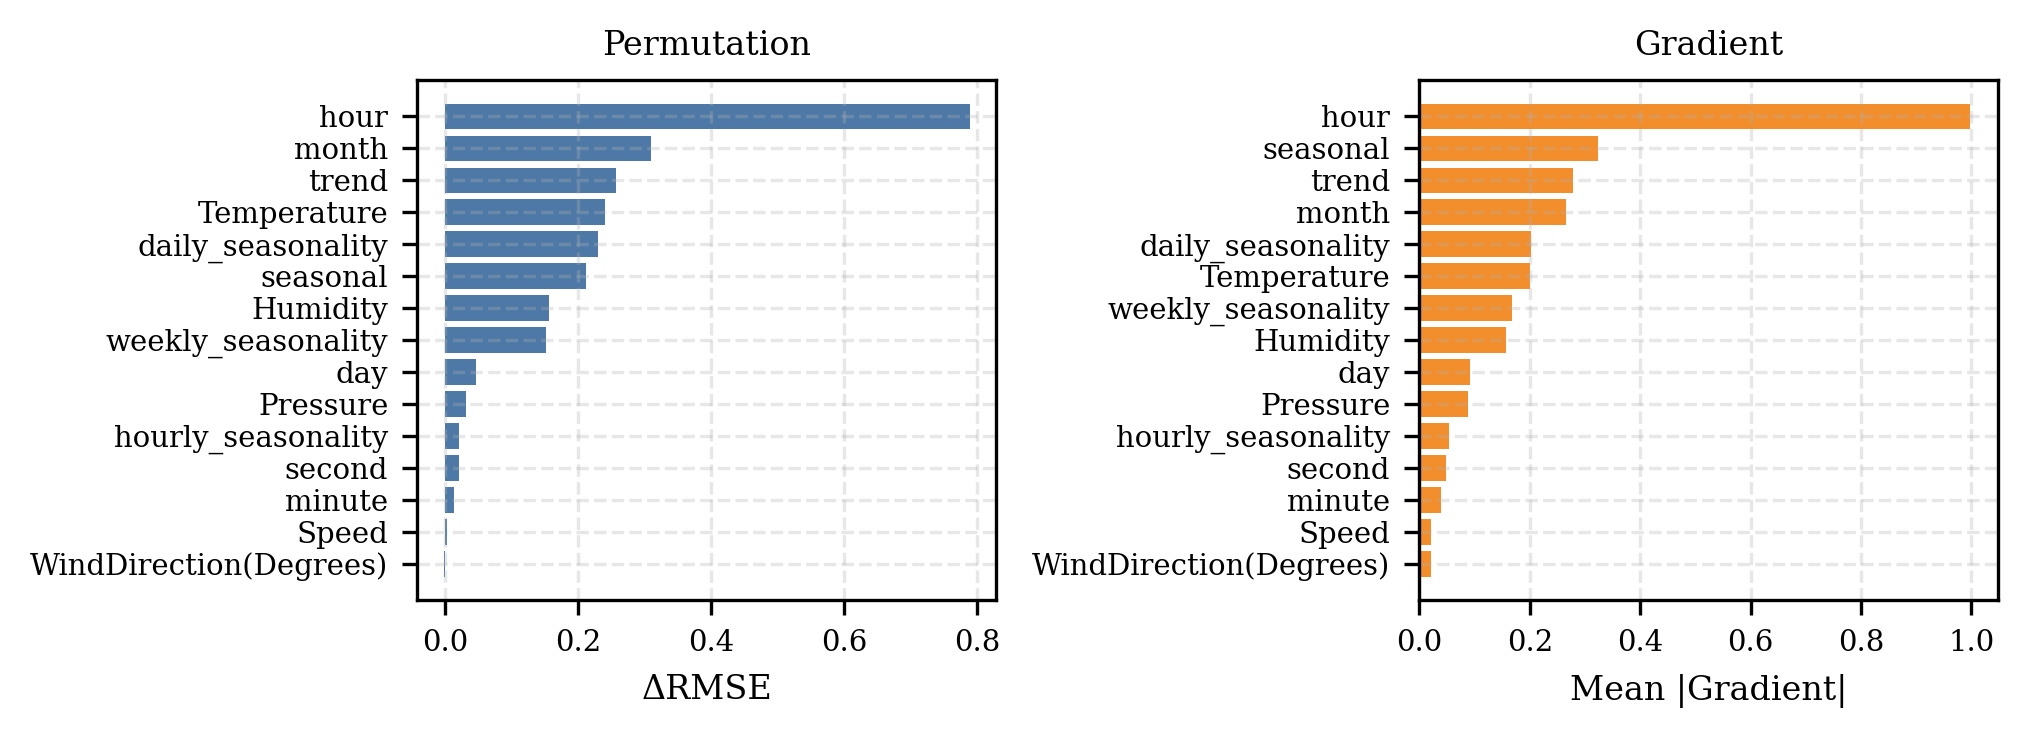

In [6]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import mean_squared_error

# ---------- PREPARE ----------
model.eval()

# Ensure all tensors are on the same device as the model
device = next(model.parameters()).device
X_test_perm = X_test_t.clone().to(device)
y_test_true = y_test_t.clone().to(device)

# Get baseline predictions and RMSE
base_preds = model(X_test_perm).detach().cpu().numpy().flatten()
base_rmse = np.sqrt(mean_squared_error(y_test_true.cpu().numpy().flatten(), base_preds))

# ---------- PERMUTATION IMPORTANCE ----------
perm_importances = []

# Input features
input_features = [
    "trend", "seasonal", 'daily_seasonality', 'hourly_seasonality', 'weekly_seasonality',
    'Temperature', 'Pressure', 'Humidity',
    'WindDirection(Degrees)', 'Speed', 'month', 'day', 'hour', 'minute', 'second'
]

for i in range(X_test_perm.shape[1]):
    X_permuted = X_test_perm.clone()
    idx = torch.randperm(X_test_perm.size(0))
    X_permuted[:, i] = X_permuted[idx, i]  # Shuffle one column
    perm_preds = model(X_permuted).detach().cpu().numpy().flatten()
    perm_rmse = np.sqrt(mean_squared_error(y_test_true.cpu().numpy(), perm_preds))
    importance = perm_rmse - base_rmse
    perm_importances.append(importance)

# Create DataFrame for permutation importance
importance_df = pd.DataFrame({
    "Feature": input_features,
    "Importance (RMSE Increase)": perm_importances
}).sort_values(by="Importance (RMSE Increase)", ascending=True)

# ---------- GRADIENT-BASED IMPORTANCE ----------
X_test_t = X_test_t.to(device)
X_test_t.requires_grad = True
grad_importances = torch.zeros(X_test_t.shape[1], device=device)

for i in range(X_test_t.shape[0]):
    model.zero_grad()
    output = model(X_test_t[i:i+1])
    output.backward(torch.ones_like(output))
    grad_importances += X_test_t.grad[i].abs().detach()

grad_importances /= X_test_t.shape[0]

# Create DataFrame for gradient importance
grad_importance_df = pd.DataFrame({
    "Feature": input_features,
    "Gradient Importance": grad_importances.cpu().numpy()
}).sort_values(by="Gradient Importance", ascending=True)

# ---------- IEEE/Elsevier STYLE PLOTTING ----------
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 8,
    "axes.labelsize": 8,
    "axes.titlesize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "figure.figsize": (3.3, 2.5),
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "grid.linestyle": "--"
})

# --- Permutation Plot ---
plt.figure()
plt.barh(importance_df["Feature"], importance_df["Importance (RMSE Increase)"], color="#4E79A7")
plt.xlabel("ΔRMSE after permutation")
plt.title("Permutation Feature Importance", pad=10)
plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\NASA\QNHITS\permutation_importance.png")
plt.show()

# --- Gradient Plot ---
plt.figure()
plt.barh(grad_importance_df["Feature"], grad_importance_df["Gradient Importance"], color="#F28E2B")
plt.xlabel("Mean Absolute Gradient")
plt.title("Gradient-based Feature Importance", pad=10)
plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\NASA\QNHITS\gradient_importance.png")
plt.show()

# --- Combined Plot (Optional) ---
fig, ax = plt.subplots(1, 2, figsize=(6.8, 2.5))
ax[0].barh(importance_df["Feature"], importance_df["Importance (RMSE Increase)"], color="#4E79A7")
ax[0].set_title("Permutation", fontsize=8)
ax[0].set_xlabel("ΔRMSE", fontsize=8)

ax[1].barh(grad_importance_df["Feature"], grad_importance_df["Gradient Importance"], color="#F28E2B")
ax[1].set_title("Gradient", fontsize=8)
ax[1].set_xlabel("Mean |Gradient|", fontsize=8)

for a in ax:
    a.tick_params(axis='both', which='major', labelsize=7)
    a.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\NASA\QNHITS\feature_importance_combined.png")
plt.show()
